<h1><center>Inference for paragraph generation</center></h1>


This notebook is used for generating paragraphs (not spans) in a `Dominant only` and `No Introduction` setup. The rouge scores are estimated after extracting the spans from the paragraphs generated

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

In [4]:
import re
import inspect
from copy import deepcopy

In [5]:
sys.path.append("../scripts/")

In [6]:
import json

In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [8]:
from transformers import Seq2SeqTrainer

In [9]:
from transformers.models.led.modeling_led import LEDModel

In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from dataset import CitationTextGenerationDataset, CitationParagraphGenerationDataset
from torch.utils.data import Dataset, DataLoader

ImportError: cannot import name 'CitationTextGenerationDataset' from 'dataset' (../scripts/dataset.py)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10, 8)
sns.set()

In [ ]:
import analysis_utils

In [ ]:
device = "cuda"

In [ ]:
max_input_length = 16384
max_output_length = 1024

### Generation/Inference on Test data

In [11]:
def process_data_to_model_inputs(batch, special_tokens=['[Dominant]', '[Reference]']):
    # tokenize the inputs and labels
    
    additional_special_tokens_lookup = {token: idx for token, idx in zip(tokenizer.additional_special_tokens, tokenizer.additional_special_tokens_ids)}
    special_token_ids = set([additional_special_tokens_lookup[token] for token in special_tokens])
    special_token_ids.add(tokenizer.mask_token_id)
    
    inputs = tokenizer(
        batch["source"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
        add_special_tokens=True 
    )
    outputs = tokenizer(
        batch["target"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
        add_special_tokens=True 
    )

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    # create 0 global_attention_mask lists
    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    # since above lists are references, the following line changes the 0 index for all samples
    for i_batch in range(len(batch["input_ids"])):
        for i_token in range(len(batch["input_ids"][0])):
            if batch["input_ids"][i_batch][i_token] in special_token_ids:
                batch["global_attention_mask"][i_batch][i_token] = 1
            
    batch["labels"] = outputs.input_ids

    # We have to make sure that the PAD token is ignored
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]
    return batch

In [12]:
path = "/home/bxm200000/models/dominant_only/led_generations/par_v1_cdlm/checkpoint-60500/"

In [16]:
tokenizer = AutoTokenizer.from_pretrained(path)
special_tokens = ['<doc>','</doc>', '[BOS]', '[Dominant]', '[Reference]', '[B_Dominant]',  '[E_Dominant]', '[B_Reference]', '[E_Reference]', '<context>', '</context>']
additional_special_tokens = {'additional_special_tokens': special_tokens}
tokenizer.add_special_tokens(additional_special_tokens)

0

In [17]:
model = AutoModelForSeq2SeqLM.from_pretrained(
    path
)

In [18]:
model.config.length_penalty = 2.

In [19]:
model = model.to(device).half()
model.eval()

LEDForConditionalGeneration(
  (led): LEDModel(
    (shared): Embedding(50276, 768, padding_idx=1)
    (encoder): LEDEncoder(
      (embed_tokens): Embedding(50276, 768, padding_idx=1)
      (embed_positions): LEDLearnedPositionalEmbedding(16384, 768, padding_idx=1)
      (layers): ModuleList(
        (0): LEDEncoderLayer(
          (self_attn): LEDEncoderAttention(
            (longformer_self_attn): LEDEncoderSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Linear(in_features=768, out_features=768, bias=True)
        

In [20]:
val_set = CitationParagraphGenerationDataset(
    "/home/data/XiangciLi/CORWA/annotated_test/", 
    tokenizer, 
    MAX_SENT_LEN = max_input_length,
    related_work_path='/home/data/XiangciLi/20200705v1/acl/selected_related_work.jsonl',
    cited_metadata_path='/home/data/XiangciLi/20200705v1/acl/selected_cited_metadata.jsonl',
    cited_paper_path="/home/data/XiangciLi/20200705v1/acl/selected_cited_pdf_parses.jsonl",
    citing_paper_path="/home/data/XiangciLi/20200705v1/acl/selected_pdf_parses.jsonl",
    skip_no_citations = True,
    context_sep_flag=True,
    include_intro=False,
    add_same_ciation = True
)

100%|██████████| 362/362 [00:08<00:00, 40.58it/s]


In [21]:
val_set.filter_citation_type(citation_type="Dominant")

In [22]:
# val_set[0]

In [23]:
def get_new_source(source):
    return related_work + "\n\n" + source.split("\n\n")[1]

In [24]:
# for dt in val_set:
#     dt["source"] = get_new_source(dt["source"])

In [17]:
def run_model(batch, model):
    processed_batch = process_data_to_model_inputs(batch, special_tokens=['[Dominant]', '[Reference]'])
    processed_batch_cuda = {}
    for key in ["input_ids", "attention_mask", "global_attention_mask", "labels"]:
        processed_batch_cuda[key] = torch.tensor(processed_batch[key]).to(device)
    predicted_abstract_ids = model.generate(
        processed_batch_cuda["input_ids"], 
        attention_mask=processed_batch_cuda["attention_mask"], 
        global_attention_mask=processed_batch_cuda["global_attention_mask"]
    )
    out = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=False)
    target = batch["target"]
    return out, target

In [18]:
def get_citations(src):
    """Get citations given source content"""
    all_citations = []
    for cite_data in src.split("[B_Reference]")[1:]:

        all_citations.append(cite_data.split("</s>")[0].strip())

    for cite_data in src.split("[B_Dominant]")[1:]:

        all_citations.append(cite_data.split("</s>")[0].strip())
    
    return all_citations

In [41]:
accumulated_data = []

#reference_predicted = []
#reference_reference = []
#dominant_predicted = []
#dominant_reference = []
for batch in tqdm(DataLoader(val_set, batch_size = 1, shuffle=False)):
    processed_batch = process_data_to_model_inputs(batch, special_tokens=['[Dominant]', '[Reference]'])
    processed_batch_cuda = {}
    for key in ["input_ids", "attention_mask", "global_attention_mask", "labels"]:
        processed_batch_cuda[key] = torch.tensor(processed_batch[key]).to(device)
    predicted_abstract_ids = model.generate(
        processed_batch_cuda["input_ids"], 
        attention_mask=processed_batch_cuda["attention_mask"], 
        global_attention_mask=processed_batch_cuda["global_attention_mask"]
    )
    out = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=False)
#     print(out)
    target = batch["target"]
    for o, t, part_id, source in zip(out, target, batch["id"], batch["source"]):
        accumulated_data.append(
            {"source": source, "target": t, 
             "generated": o, "part_id": part_id}
        )

In [62]:
# analysis_utils.write_json(
#     accumulated_data, 
#     os.path.abspath(os.path.join(path, "../sample_output.json"))
# )

In [47]:
path = "/home/bxm200000/models/dominant_only/led_generations/span_v1_cdlm/checkpoint-67500/"

In [48]:
accumulated_data = analysis_utils.load_json(
    os.path.abspath(os.path.join(path, "../sample_output.json")) 
)

### Post-Process paragraph Generation

In [281]:
from thefuzz import fuzz

def fuzzy_replace(pattern, repl, string):
    l = len(pattern.split()) # Length to read orig_str chunk by chunk
    splitted = string.split()
    for i in range(len(splitted)-l+1):
        for k in range(3):
            test = " ".join(splitted[max(0, i - k) : min(len(splitted), i+l + k)])
            if fuzz.ratio(pattern, test) > 75: #Using fuzzwuzzy library to test ratio
                before = " ".join(splitted[:max(0, i - k)])
                after = " ".join(splitted[min(len(splitted), i+l + k):])
                return_string = before+" "+repl+" "+after
                return return_string.strip(), True #Output will be sandwich of these three strings
    return string.strip(), False

In [282]:
def strip_context(paragraph):
    """strip context from paragraph and only return span"""
    return paragraph.split("<context>")[1].split("</context>")[0].strip()

In [292]:
citation_valid_count = 0
citation_valid_count_target = 0
total_cites = 0
truth, prediction = [], []
bad_citations = []
for data in accumulated_data:
    
# if "<context>" in data["generated"] and "</context>" in data["generated"]:

    target = data["target"]
    generation = data["generated"]
    target = analysis_utils.remove_punctuations_from_citations(target)    
    generation = analysis_utils.remove_punctuations_from_citations(generation)    

    cite_found = False
    citation_marks  = analysis_utils.get_citations(data["source"])
    total_cite_marks = len(citation_marks)
    counter = 0
    for cite in citation_marks:
        total_cites += 1
        cite = analysis_utils.remove_punctuations_from_citations(cite)

        if cite in target:
            #         if found:
            target = target.replace(cite, "")
            citation_valid_count_target += 1
#             else:
#                 target, found = analysis_utils.fuzzy_replace(cite, "", target)

        if cite in generation:
#         if found:
            generation = generation.replace(cite, "")
            cite_found = True
            counter += 1
            citation_valid_count += 1
        else:
            bad_citations.append((cite, generation))
            generation, found = fuzzy_replace(cite, "", generation)
            if found:
                citation_valid_count += 1

#         target = target.replace(cite, "")
#         generation = generation.replace(cite, "")

#         if cite_found and counter == total_cite_marks:

    truth.append(target)
    prediction.append(generation)

In [293]:
citation_valid_count, citation_valid_count_target, total_cites

(1265, 1503, 1538)

In [294]:
rouge.compute(
    predictions=prediction, 
    references=truth, 
    rouge_types=["rouge1","rouge2","rougeL"],           
    use_stemmer=True
)

{'rouge1': AggregateScore(low=Score(precision=0.2630729884201392, recall=0.28429534882319013, fmeasure=0.24741453254908688), mid=Score(precision=0.2714446877434547, recall=0.29324796387017177, fmeasure=0.25448054483797333), high=Score(precision=0.27975659178423223, recall=0.3021206090975524, fmeasure=0.26116541210016003)),
 'rouge2': AggregateScore(low=Score(precision=0.06270512435123805, recall=0.06899337951986224, fmeasure=0.059071821587468286), mid=Score(precision=0.0676382120896212, recall=0.0744553134507854, fmeasure=0.06349954990113339), high=Score(precision=0.07297767247352686, recall=0.080476118053848, fmeasure=0.06842291602236568)),
 'rougeL': AggregateScore(low=Score(precision=0.19818478187526314, recall=0.21697656151708486, fmeasure=0.18776953651489756), mid=Score(precision=0.20512478708921505, recall=0.22471123315113284, fmeasure=0.1935324190802918), high=Score(precision=0.21226149967637012, recall=0.23222270559398767, fmeasure=0.1997092780503558))}

In [89]:
new_accumulated_data = deepcopy(accumulated_data)

In [90]:
predicted, references = [], []
dominant_predicted, dominant_reference = [], []
reference_predicted, reference_reference = [], []
for index, data in enumerate(new_accumulated_data):
    target = data["target"]
    gen = data["generated"]
    
    
    if "<context>" in gen and "</context>" in gen:

        target = strip_context(data["target"])
        gen = strip_context(data["generated"])
        data["generated"] = gen
        data["target"] = target

        new_accumulated_data[index] = data
        # remove citations         
        for c in get_citations(data["source"]):
            c = c.replace(",", "").replace(".", "")
            gen = gen.replace(",", "").replace(".", "").replace(c, "")
            target = target.replace(",", "").replace(".", "").replace(c, "")

        predicted.append(gen)
        references.append(target)

        if "[Dominant]" in data["source"]:
            dominant_predicted.append(gen)
            dominant_reference.append(target)


        if "[Reference]" in data["source"]:
            reference_predicted.append(gen)
            reference_reference.append(target)


In [91]:
len(dominant_predicted)

1317

In [22]:
accumulated_data = [x for x in accumulated_data if "<context>" not in x["target"]]

In [58]:
predicted = [analysis_utils.remove_citation_from_sentence(
    x["generated"], x["source"]) for x in accumulated_data]

references = [analysis_utils.remove_citation_from_sentence(
    x["target"], x["source"]) for x in accumulated_data]

In [59]:
len(predicted), len(references)

(1271, 1271)

## Rouge Scores

In [60]:
rouge = load_metric("rouge")

In [92]:
rouge.compute(
    predictions=predicted, 
    references=references, 
    rouge_types=["rouge1","rouge2","rougeL"],           
    use_stemmer=True
)

{'rouge1': AggregateScore(low=Score(precision=0.24390280193448513, recall=0.2918351856668053, fmeasure=0.24679456410476389), mid=Score(precision=0.2511805527825172, recall=0.29988851296425945, fmeasure=0.2527202804293941), high=Score(precision=0.2595020796084716, recall=0.3084939390424027, fmeasure=0.259299420535417)),
 'rouge2': AggregateScore(low=Score(precision=0.055788757664991466, recall=0.06641996068229464, fmeasure=0.0560660497814295), mid=Score(precision=0.06031282734257353, recall=0.07199184742085965, fmeasure=0.060523176233065454), high=Score(precision=0.0654290394283746, recall=0.07786736270257734, fmeasure=0.06544428245409971)),
 'rougeL': AggregateScore(low=Score(precision=0.18349067504551142, recall=0.22309379254538952, fmeasure=0.18673939053803326), mid=Score(precision=0.18957654595085724, recall=0.2297622750505995, fmeasure=0.19189791523602023), high=Score(precision=0.1956725732882889, recall=0.23735603869967975, fmeasure=0.19742646940949132))}

In [40]:
good_datapoints = deepcopy(accumulated_data)

In [41]:
lenthg_targets = np.array([tokenizer.tokenize(x["target"]).__len__() for x in good_datapoints])

In [42]:
length_generations = np.array([tokenizer.tokenize(x["generated"]).__len__() for x in good_datapoints])

(array([  2.,   1.,   0.,   3.,   3.,  23., 153., 954., 119.,  13.]),
 array([-365. , -316.1, -267.2, -218.3, -169.4, -120.5,  -71.6,  -22.7,
          26.2,   75.1,  124. ]),
 <BarContainer object of 10 artists>)

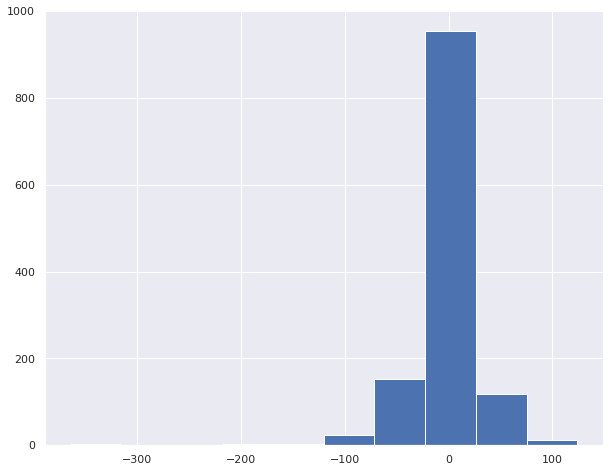

In [43]:
plt.hist(lenthg_targets - length_generations)

In [1]:
np.mean(lenthg_targets - length_generations)

NameError: name 'np' is not defined

In [45]:
np.mean(abs(lenthg_targets - length_generations))

19.47836349331235

Text(0.5, 1.0, 'Target length - Generation Length - Paragraph generation')

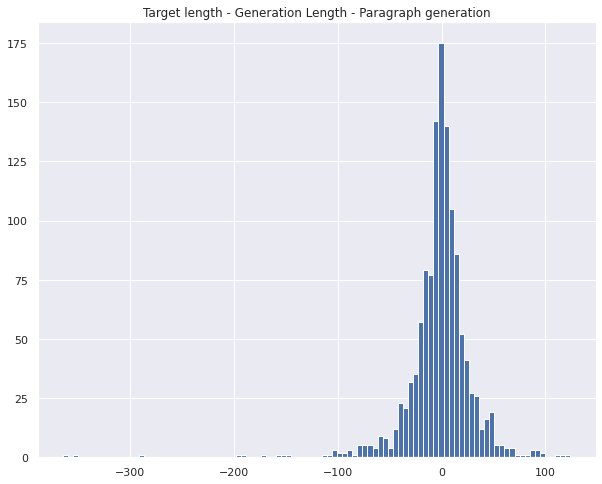

In [55]:
plt.hist(lenthg_targets - length_generations, bins=100)
plt.title("Target length - Generation Length - Paragraph generation")

### Run Text Generation on single datapoint - Exploration

In [48]:
source = """While some work has conducted experiments with different BPE settings, they are generally very limited in the range of configurations explored.\nFor example, Sennrich et al. (2016) , the original paper that proposed the BPE method, compared the system performance when using 60k separate BPE and 90k joint BPE.\nThey found 90k to work better and used that for their subsequent winning WMT 2017 new translation shared task submission (Sennrich et al., 2017) .\nWu et al. (2016) , on the other hand, found 8k-32k merge operations achieving optimal BLEU score performance for the wordpiece method.\nDenkowski and Neubig (2017) explored several hyperparameter settings, including number of BPE merge operations, to establish strong baseline for NMT on LSTM-based architectures.\nWhile Denkowski and Neubig (2017) showed that BPE models are clearly better than word-level models, their experiments on 16k and 32k BPE configuration did not show much difference.\nThey therefore recommended \"32K as a generally effective vocabulary size and 16K as a contrastive condition when building systems on less than 1 million parallel sentences\".\nHowever, while studying deep character-based LSTM-based translation models,  [Dominant] \nRecently, Renduchintala et al. (2018) also showed that it is important to tune the number of BPE merge operations and found no typical optimal BPE configuration for their LSTM-based architecture while sweeping over several language pairs in the low-resource setting.\nIt should be noticed that the results from the above studies actually contradict with each other, and there is still no clear consensus as to what is the best practice for BPE application.\nMoreover, all the work surveyed above was done with LSTM-based architectures.\nTo this day, we are not aware of any work that explored the interaction of BPE with the Transformer architecture.\n\n [B_Dominant] Du et al. (2017) </s> Learning to Ask: Neural Question Generation for Reading Comprehension | We study automatic question generation for sentences from text passages in reading comprehension. We introduce an attention-based sequence learning model for the task and investigate the effect of encoding sentence-vs. paragraph-level information. In contrast to all previous work, our model does not rely on hand-crafted rules or a sophisticated NLP pipeline; it is instead trainable end-to-end via sequenceto-sequence learning. Automatic evaluation results show that our system significantly outperforms the state-of-the-art rule-based system. In human evaluations, questions generated by our system are also rated as being more natural (i.e., grammaticality, fluency) and as more difficult to answer (in terms of syntactic and lexical divergence from the original text and reasoning needed to answer). [E_Dominant]"""

In [43]:
target = "Shen et al. (2019) proposed ml-VAE-D with multi-level latent variables."

In [46]:
def get_generation(gen_model, source):
    test_data = {"source": source, "target": "target 123", "id": "test_123"}

    test_data_list = [test_data]
    for batch in DataLoader(test_data_list, batch_size = 1, shuffle=False):
        out, ta = run_model(batch, gen_model)
        break
    return out[0]
#     return strip_context(out[0])

In [49]:
get_generation(model, source)

'</s><s>While some work has conducted experiments with different BPE settings, they are generally very limited in the range of configurations explored.\nFor example, Sennrich et al. (2016), the original paper that proposed the BPE method, compared the system performance when using 60k separate BPE and 90k joint BPE.\nThey found 90k to work better and used that for their subsequent winning WMT 2017 new translation shared task submission (Sennrich Et al., 2017).\nWu et al., 2016), on the other hand, found 8k-32k merge operations achieving optimal BLEU score performance for the wordpiece method.\nDenkowski and Neubig (2017) explored several hyperparameter settings, including number of BPE merge operations, to establish strong baseline for NMT on LSTM-based architectures.\nWhile Denkowski andNeubig the2017) showed that BPE models are clearly better than word-level models, their experiments on 16k and 32k BPE configuration did not show much difference.\nthey therefore recommended "32K as a 

In [33]:
cited_paper = """[B_Dominant] Michel and Neubig (2018) </s> Extreme Adaptation for Personalized Neural Machine Translation | Every person speaks or writes their own flavor of their native language, influenced by a number of factors: the content they tend to talk about, their gender, their social status, or their geographical origin. When attempting to perform Machine Translation (MT), these variations have a significant effect on how the system should perform translation, but this is not captured well by standard one-sizefits-all models. In this paper, we propose a simple and parameter-efficient adaptation technique that only requires adapting the bias of the output softmax to each particular user of the MT system, either directly or through a factored approximation. Experiments on TED talks in three languages demonstrate improvements in translation accuracy, and better reflection of speaker traits in the target text. [E_Dominant]"""

In [28]:
def get_context(source):
    return source.split("\n\n")[0]

In [1]:
# for i in range(0, len(val_set), 20):
#     ddd = val_set[i]
#     source = get_context(ddd["source"]) + "\n\n" + cited_paper
#     try:
#         print(get_generation(model, source))
#     except:
#         pass
#     print("\n\n")